In [1]:
!nvidia-smi

Sat Jun 25 10:43:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Image Captioning
- Generating Captions for Images
- Using the flicker 8k dataset (2 gb)
- One More Large Dataset Exist Flicker Image Dataset (4 gb)

### Steps 
- Data collection
- Understanding the data
- Data Cleaning
- Loading the training set
- Data Preprocessing — Images
- Data Preprocessing — Captions
- Data Preparation using Generator Function
- Word Embeddings
- Model Architecture
- Inference


   Out Of 8000 images,6000 images are assigned for training 1000 for validation and 
   remaining 1000 for testing.
   For each image we are given 5 captions.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
# Regular Expression
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [12]:
# Read Text Captions
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [13]:
# It contains all the captions
captions  = readTextFile("./drive/MyDrive/Flicker_8k_dataset/Data/Flickr_TextData/Flickr8k.token.txt")
# Split the captions along new line char and discard the last caption as it contains 
# only a new line char
captions = captions.split('\n')[:-1]

In [14]:
print(len(captions))
print(captions[0])

40460
1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .


In [15]:
# Split the caption zero around the tab
first,second  = captions[0].split('\t')
# Split the first part along full stop and pick the zeroth element
print(first.split(".")[0])
print(second)

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [ ]:
# Dictionary to Map each Image with the list of captions it has

In [16]:
# Each image in the dictionary contains a list of captions
descriptions = {}

for x in captions:
    first,second = x.split('\t')
    img_name = first.split(".")[0]
    
    #if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    
    descriptions[img_name].append(second)

In [17]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

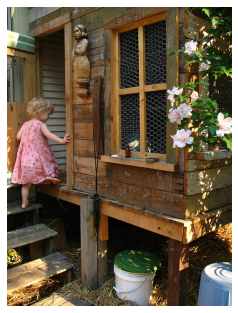

In [18]:
IMG_PATH = "drive/MyDrive/Flicker_8k_dataset/Data/Images/"
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

### Data Cleaning 

In [19]:
# We are not going to remove stopwords and also not going to do stemming.
# We are only going to remove all non alphabetic characters and all the words
# which are less than or equal to length 1.
"""
   This is going to make the vocab size small.
   Advantage Of small Vocab size?
   At last Our Model is going to predict the probabilities of each word in the vocab for a 
   given image.If the Vocab size is small then in the dense layer we are going to have less
   number of Neurons.This Implies that We are going to learn less number of parameters.Therefore
    Chance Of Overfitting Is going to decrease. 
"""
def clean_text(sentence):
    sentence = sentence.lower()
    """
    [^a-z]->It indicates that the char which are not alphabet
    """
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence  = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [20]:
clean_text("A cat is sitting over the house # 64")

'cat is sitting over the house'

In [21]:
# Clean all Captions
# Iterate over each caption in the dictionary and apply the clean_text() function
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [22]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [23]:
# Write the cleaned data to text file
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

### Vocabulary 

---


- Set Of all Unique Words model can Predict

In [24]:
"""
 We are going to create vocab as the model is going to predict the probilities.
 By creating A vocab we are going to cross Map the Highest Probabilities predicted
  By Our Model into Words.
"""
"""
It Is a Good Practice to store the data in text file so that preprocessing gets easier.
This Is Done Just beacuse to make us understand how to convert the text again into 
dictionary.
We can Even Omit This Cell.
"""
descriptions = None
with open("descriptions_1.txt",'r') as f:
    # Here description is a string
    descriptions= f.read()
    
json_acceptable_string = descriptions.replace("'","\"")
# Converts the string to a python dictionary
descriptions = json.loads(json_acceptable_string)

In [25]:
print(type(descriptions))

<class 'dict'>


In [26]:
print(descriptions["1000268201_693b08cb0e"])

['child in pink dress is climbing up set of stairs in an entry way', 'girl going into wooden building', 'little girl climbing into wooden playhouse', 'little girl climbing the stairs to her playhouse', 'little girl in pink dress going into wooden cabin']


In [27]:
# Vocab
# Set Contains Unique Words
vocab = set()
for key in descriptions.keys():
    # sentence.split() is going to split the sentences into words as we wnat to 
    # store words in our vocab
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


In [28]:
# Total No of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words :%d"%len(total_words))

Total Words :373837


In [ ]:
"""
Vocab Size : 8424
Total Words : 373837
We Can Clearly See The differnce Between the Vocab size and the total words.
If We would have feed total words in our model then the model would have overfitted
But By creating Vocab We have reduced the word count Significantly.
"""

'\nVocab Size : 8424\nTotal Words : 373837\nWe Can Clearly See The differnce Between the Vocab size and the total words.\nIf We would have feed total words in our model then the model would have overfitted\nBut By creating Vocab We have reduced the word count Significantly.\n'

In [ ]:
# Filter Words from the Vocab according to certain threshold frequncy(i.e, Again shortening the vocab size)

In [29]:
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
# Length Of frequency count is going to the number of unique words
print(len(freq_cnt.keys()))

8424


In [30]:
print(freq_cnt)

{'child': 1545, 'in': 18987, 'pink': 739, 'dress': 348, 'is': 9345, 'climbing': 507, 'up': 1302, 'set': 109, 'of': 6723, 'stairs': 109, 'an': 2432, 'entry': 1, 'way': 53, 'girl': 3328, 'going': 149, 'into': 1074, 'wooden': 284, 'building': 511, 'little': 1768, 'playhouse': 6, 'the': 18420, 'to': 3176, 'her': 1178, 'cabin': 4, 'black': 3848, 'dog': 8138, 'and': 8863, 'spotted': 38, 'are': 3505, 'fighting': 133, 'tri': 14, 'colored': 221, 'playing': 2008, 'with': 7765, 'each': 430, 'other': 773, 'on': 10746, 'road': 398, 'white': 3959, 'brown': 2578, 'spots': 29, 'staring': 57, 'at': 2916, 'street': 944, 'two': 5643, 'dogs': 2125, 'different': 46, 'breeds': 5, 'looking': 744, 'pavement': 48, 'moving': 41, 'toward': 146, 'covered': 372, 'paint': 62, 'sits': 577, 'front': 1386, 'painted': 64, 'rainbow': 22, 'hands': 246, 'bowl': 30, 'sitting': 1368, 'large': 1237, 'small': 1278, 'grass': 1622, 'plays': 526, 'fingerpaints': 3, 'canvas': 6, 'it': 401, 'there': 304, 'pigtails': 14, 'painting'

In [31]:
# Sort this dictionary according to the freq count
# Sorted function works on a list and freq_cnt.items() is going to generate a list
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# Filter
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [32]:
print(len(total_words))

1845


In [33]:
"""
The vocab size is reduced from 8424 to 1845
"""

'\nThe vocab size is reduced from 8424 to 1845\n'

### Prepare Train/Test Data

In [34]:
train_file_data = readTextFile("drive/MyDrive/Flicker_8k_dataset/Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("drive/MyDrive/Flicker_8k_dataset/Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [35]:
print(train_file_data)

2513260012_03d33305cf.jpg
2903617548_d3e38d7f88.jpg
3338291921_fe7ae0c8f8.jpg
488416045_1c6d903fe0.jpg
2644326817_8f45080b87.jpg
218342358_1755a9cce1.jpg
2501968935_02f2cd8079.jpg
2699342860_5288e203ea.jpg
2638369467_8fc251595b.jpg
2926786902_815a99a154.jpg
2851304910_b5721199bc.jpg
3423802527_94bd2b23b0.jpg
3356369156_074750c6cc.jpg
2294598473_40637b5c04.jpg
1191338263_a4fa073154.jpg
2380765956_6313d8cae3.jpg
3197891333_b1b0fd1702.jpg
3119887967_271a097464.jpg
2276499757_b44dc6f8ce.jpg
2506892928_7e79bec613.jpg
2187222896_c206d63396.jpg
2826769554_85c90864c9.jpg
3097196395_ec06075389.jpg
3603116579_4a28a932e2.jpg
3339263085_6db9fd0981.jpg
2532262109_87429a2cae.jpg
2076906555_c20dc082db.jpg
2502007071_82a8c639cf.jpg
3113769557_9edbb8275c.jpg
3325974730_3ee192e4ff.jpg
1655781989_b15ab4cbff.jpg
1662261486_db967930de.jpg
2410562803_56ec09f41c.jpg
2469498117_b4543e1460.jpg
69710415_5c2bfb1058.jpg
3414734842_beb543f400.jpg
3006217970_90b42e6b27.jpg
2192411521_9c7e488c5e.jpg
3535879138_9281d

In [36]:
train_file_data[-1]

'\n'

In [37]:
# Do it for all the rows except the last row as it only contains a new line char
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [38]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [39]:
# Prepare Description for the Training Data
# Tweak - Add <s> and <e> token to our training data 
"""
   Since We are Going to use a RNN/LSTM Based Model For Text Generation.During The Text
   Generation If the Model Generates <e> Token then It Indicates That Our Sentence Has
   Ended.And We need to terminate the RNN call so that furthur no more words get generated.
   For The RNN Model to predict the token <e> we need to add the token in our training
   Data.
   We are Going to add two tokens <s>-Start tokens and <e>-End Token.
"""
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq "  + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [40]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

### Transfer Learning
- Images --> Features
- Text ---> Features 

### Step - 1 Image Feature Extraction

In [41]:
# Resnet Is not a sequential model.It Offers Branches and Skip Connections.
# Skip Connection Allows networks to learn without facing the issue of vanishing gradient.
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

102981632/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [42]:
model.layers[-2].output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'avg_pool')>

In [43]:
"""
*We are Only Going to use the features learned by Resnet50 model on imageNet(1.4 Million 
Images Belonging to 1000 classes)Dataset.
*avg_pool (GlobalAveragePooling2 (None, 2048) ->The second last layer in the resnet50
model.
*This layer contains all the features learned by the resnet 50 model on the imagenet 
dataset in a 2048 dimensional vector.
* Each Of Our Image in the dataset Is Going To be represented as a feature vector
of (2048 dimensions).
"""
"""
The new model contains the convolutional base(feature extractor) part of resnet50.
*image (m images)(224*224*3)-->prepocess_input(image)-->preproceesed image-->
(Resnet50 conv Bsse)--> (m*2048)(output dim).
After that store the features in the disk.
"""
model_new = Model(model.input,model.layers[-2].output)

In [44]:
model_new.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [45]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    # As we are going to feed a batch of images to our model.
    # The expand_dims function converts it to a 4d tensor (1*224*224*3)
    # 1 image of(224*224*3) dims.
    img = np.expand_dims(img,axis=0)
    # Normalisation
    # This function is available with resnet50 model.
    # We will also preprocess our data in same way as preprocessed by resnet50
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


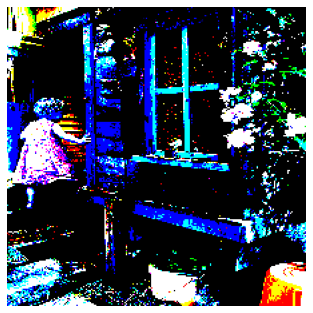

In [46]:
"""
preprocess_input actually subtracts each pixel value of our image from the mean value 
obtained from the imagenet dataset.
Mean for (Red,Blue and Green) channel on the whole imagnet is suppose ->(x,y,z)
lets suppose some pixel value of our image is (a,b,c).
Now when we feed this pixel to preprocess_input function it subtracts each pixel from the
mean value like a=(x-a);b=(y-b);c=(z-c).Therefore we will get a different pixel value
And matplotlib is unable to distinguish this difference.Therefore it is plotting the image
differntly.
"""
img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
# img is a 4d tensor
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [47]:
"""
*preprocess_input is a function of resnet.
*image (m images)(224*224*3)-->prepocess_input(image)-->preproceesed image-->
(Resnet50 conv Bsse)--> (m*2048)(output dim).
"""
# This function encodes an image into a feature vector of 2048 dimensions.
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,))
#     print(feature_vector.shape)
    return feature_vector

In [48]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg").shape

(2048,)

In [ ]:
"""
This Process Is Very time Consuming.Therefore We will Create the encoding Between The 
image_id and the feature vectore store it on our disk.So that we don't need to execute
this cell whenever we run our project from scratch.
"""
start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Encoding in Progress Time step 1000 
Encoding in Progress Time step 1100 
Encoding in Progress Time step 1200 
Encoding in Progress Time step 1300 
Encoding in Progress Time step 1400 
Encoding in Progress Time step 1500 
Encoding in Progress Time step 1600 
Encoding in Progress Time step 1700 
Encoding in Progress Time step 1800 
Encoding in Progress Time step 1900 
Encoding in Progress Time step 2000 
Encoding in Progress Time step 2100 
Encoding in Progress Time step 2200 
Encoding in Progress Time step 2300 
Encoding in Progress Time step 2400 
Encoding in Progress Time step 2500 
Encoding in Progress Time step 2600 
Encoding in P

In [ ]:
!mkdir saved

In [ ]:
# Store everything to the disk
"""
We are going to use pickle to store the encoded data from ram to the disk.
"""
with open("saved/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [ ]:
# Do the encoding for the test data as well.
start = time()
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken(test) :",end_t-start)

Test Encoding in Progress Time step 0 
Test Encoding in Progress Time step 100 
Test Encoding in Progress Time step 200 
Test Encoding in Progress Time step 300 
Test Encoding in Progress Time step 400 
Test Encoding in Progress Time step 500 
Test Encoding in Progress Time step 600 
Test Encoding in Progress Time step 700 
Test Encoding in Progress Time step 800 
Test Encoding in Progress Time step 900 
Total Time Taken(test) : 320.8447296619415


In [ ]:
with open("saved/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

#### Data pre-processing for Captions (Converting Captions to numerical Values)

In [49]:
# Vocab
print(len(total_words))
print(type(total_words))

1845
<class 'list'>


In [50]:
"""
*since the total word is just a list.Therefore we are going to create a mapping between
word and idx.
*While feeding these text to the glove vector to create the embediing layer inspite of 
passing the word we will pass the idx of that word.

"""
word_to_idx = {}
idx_to_word = {}
"""
We are going to reserve the zeroth index.
"0":0->(key,value)
If some of the sentences have length less than max_length then we are going to add zero
padding.That's why we have mapped 0->0.
"""
for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [51]:
#word_to_idx["dog"]
#idx_to_word[1]
print(len(idx_to_word))

1845


In [52]:
"""
We need to add <s> and <e> to our dictionary
"""
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [53]:
print(idx_to_word)

{1: 'in', 2: 'the', 3: 'on', 4: 'is', 5: 'and', 6: 'dog', 7: 'with', 8: 'man', 9: 'of', 10: 'two', 11: 'white', 12: 'black', 13: 'boy', 14: 'are', 15: 'woman', 16: 'girl', 17: 'to', 18: 'wearing', 19: 'at', 20: 'people', 21: 'water', 22: 'red', 23: 'young', 24: 'brown', 25: 'an', 26: 'his', 27: 'blue', 28: 'dogs', 29: 'running', 30: 'through', 31: 'playing', 32: 'while', 33: 'shirt', 34: 'down', 35: 'standing', 36: 'ball', 37: 'little', 38: 'grass', 39: 'snow', 40: 'child', 41: 'person', 42: 'jumping', 43: 'over', 44: 'three', 45: 'front', 46: 'sitting', 47: 'holding', 48: 'up', 49: 'field', 50: 'small', 51: 'by', 52: 'large', 53: 'green', 54: 'one', 55: 'group', 56: 'yellow', 57: 'her', 58: 'walking', 59: 'children', 60: 'men', 61: 'into', 62: 'air', 63: 'beach', 64: 'near', 65: 'mouth', 66: 'jumps', 67: 'another', 68: 'for', 69: 'street', 70: 'runs', 71: 'its', 72: 'from', 73: 'riding', 74: 'stands', 75: 'as', 76: 'bike', 77: 'girls', 78: 'outside', 79: 'other', 80: 'off', 81: 'out',

In [54]:
"""
We are going to feed a batch of sentence to the RNN cell.Therefore we wll make
each sentence equals to max_length.
Finding The max length sentence in the dataset.
If some of the sentences are having smaller size then we are going to add 0 padding .
"""
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


### Data Loader (Generator)

In [55]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, num_photos_per_batch):
  
    # x1->image;X2->caption;Y-target word
    X1, X2, y = [], [], []

    n=0

    while True:
        
        for key, desc_list in train_descriptions.items():
            n +=1

            photo = encoding_train[key]

            for desc in desc_list:
                
                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx]  

                for i in range(1,len(seq)):

                    in_seq = seq[0:i]
                    out_seq = seq[i]

                    #0 denote padding word (functions available in keras)
                    #pad_sequences and to_categorical produces 2d matrix
                    # since we are taking one image therefore we will pick the first row.
                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                
                # It is generator and it remembers the previous state
                # yield [[np.array(X1),np.array(X2)],np.array(y)]
                yield  [np.array(X1), np.array(X2)],np.array(y)
                X1, X2, y = [], [], []
                n=0

## Word Embeddings (Transfer Learning)

In [56]:
# We are going to use glove vector.
f=open("drive/MyDrive/Flicker_8k_dataset/glove.6B.50d.txt",encoding='utf8')

In [57]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

In [58]:
f.close()

In [59]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [60]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        """
        If some of the word present in our vocab is not present in the glove vector then
        we will make the embedding as zero
        """
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [61]:
# We have the vocab size as 1848. and after passing it to the glove vector it gets
# converted to a matrix of (1848*50)
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [62]:
"""
<s> and <e> is not present in glove vector.so we made it zero
"""
embedding_matrix[1847]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Model Architecture

In [63]:
input_img_features = Input(shape=(2048,)) # Extracted By using resnet50 model
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [64]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [65]:
# Adding the output obtained by processing the image and the captions
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [66]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 50)       92400       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [67]:
# Important Thing - Embedding Layer
# We are pre-initializing the weights of embedding layer by the weights of glove vector
# There is no requirement to train the table
# We have generated the embedding_matrix by using the glove vector
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [68]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

### Training of Model

In [ ]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

In [ ]:
def train():
    
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')

In [ ]:
train()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


   3/2000 [..............................] - ETA: 52s - loss: 3.1399

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2000/2000 [==============================] - 50s 25ms/step - loss: 2.5560


In [69]:
model = load_model('drive/MyDrive/Flicker_8k_dataset/model_weights/model_9.h5')

## Predictions

In [70]:
# Load the train images features from disk

with open('drive/MyDrive/Flicker_8k_dataset/saved/encoded_train_features.pkl', "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)

In [71]:
# Load the test images features from disk

with open('drive/MyDrive/Flicker_8k_dataset/saved/encoded_test_features.pkl', "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

In [72]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1] #Remove <s> and <e>
    final_caption = ' '.join(final_caption)
    return final_caption

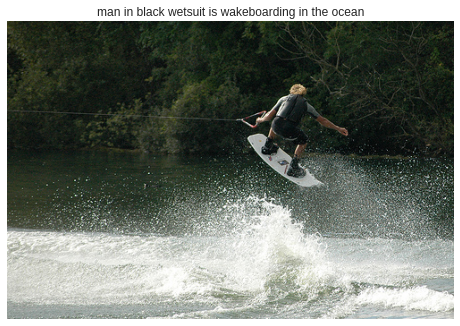

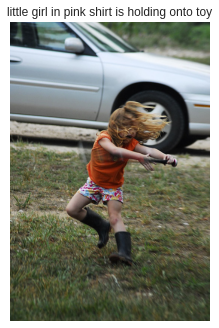

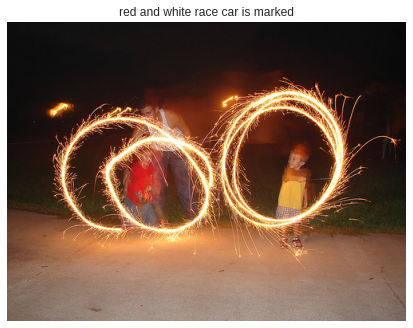

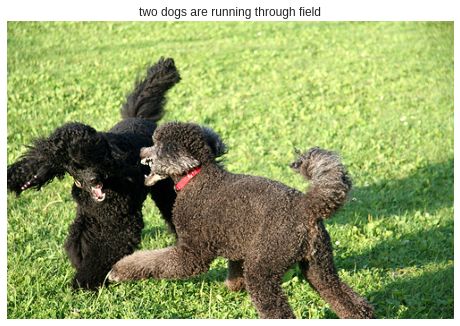

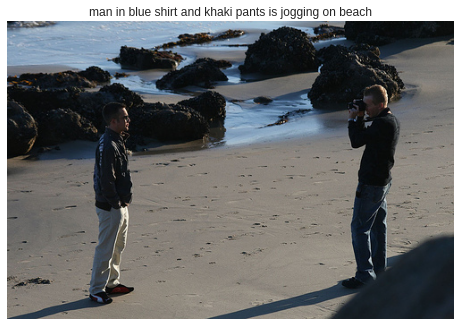

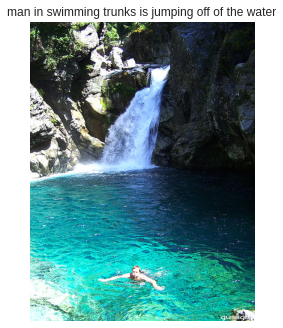

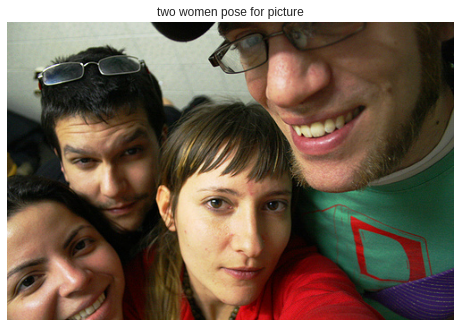

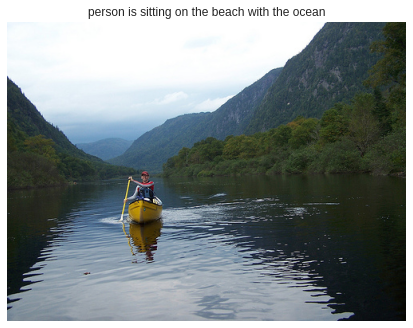

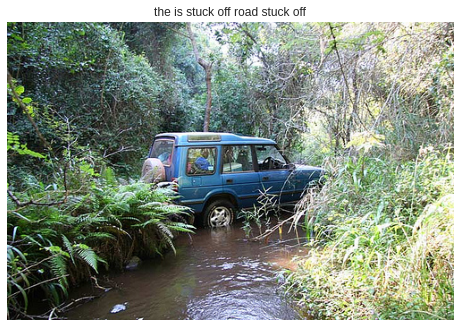

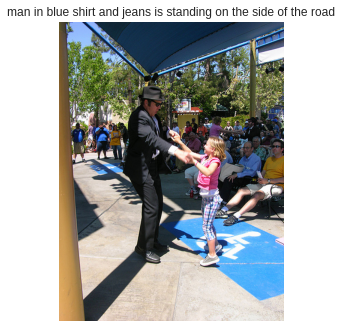

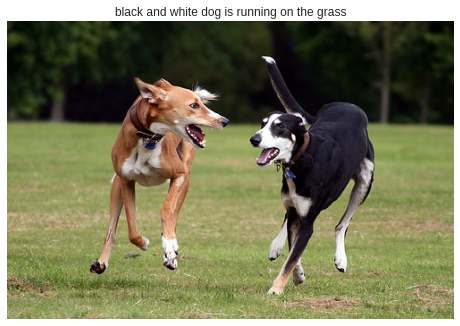

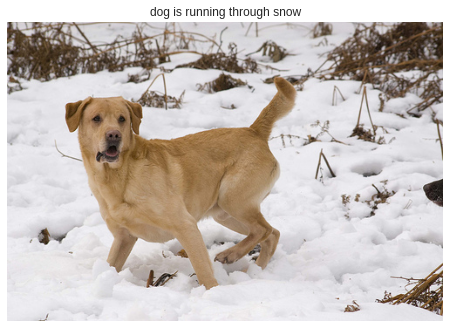

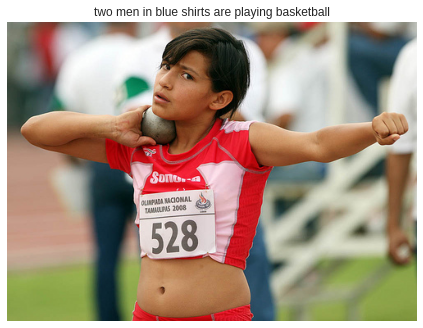

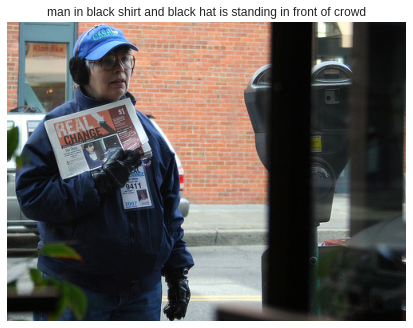

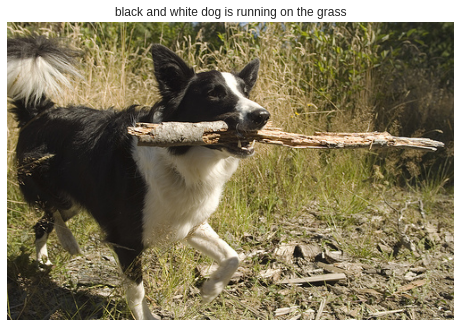

In [73]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000) # We have 1000 iamge in the testset
    all_img_names = list(encoding_test.keys()) 
    img_name = all_img_names[idx]
    # The output image will also be 2048 dimensional
    photo_2048 = encoding_test[img_name].reshape((1,2048)) # Prediction for 1 image at a tme.and
    
    i = plt.imread("drive/MyDrive/Flicker_8k_dataset/Data/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

In [74]:
encoding_test["3385593926_d3e9c21170"].shape

(2048,)